In [32]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [33]:
stan_code = """

data {
    int<lower=1> N; //Size of the training set
    int<lower=1> M; //Size of the test set
    matrix[N, 3] x_train;
    matrix[M, 3] x_test;
    vector[N] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

model {
    sigma ~ inv_gamma(0.3, 0.6);
    alpha ~ normal(0, 1);
    beta ~ normal(0, 1);

    for (n in 1:N) {
        y[n] ~ normal(alpha + beta' * (x_train[n]'), sigma);
    }
}

generated quantities{
  array[N] real gen_distr;
  array[M] real pred_distr;
  for(i in 1:N){
    gen_distr[i] = normal_rng(alpha + beta' * (x_train[i]'), sigma);
  }

  for(i in 1:M){
    pred_distr[i] = normal_rng(alpha + beta' * (x_test[i]'), sigma);
  }
}

"""

In [34]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

insurance_data = insurance_data.sample(frac=1).reset_index(drop=True)

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

parameter_vals = key_param_df.values
charges_vals = insurance_data["charges"].values

num_rows = parameter_vals.shape[0]

#Split data
split_proportion = 0.1
split_row = int(num_rows * split_proportion)

training_data_params = parameter_vals[split_row:, :]
testing_data_params = parameter_vals[:split_row, :]

training_data_charges = charges_vals[split_row:]
testing_data_charges = charges_vals[:split_row]

#Normalize data
training_data_params = (training_data_params - np.mean(training_data_params, axis=0)) / np.std(training_data_params, axis=0)
testing_data_params = (testing_data_params - np.mean(testing_data_params, axis=0)) / np.std(testing_data_params, axis=0)

training_data_charges = (training_data_charges - np.mean(training_data_charges)) / np.std(training_data_charges)
testing_data_charges = (testing_data_charges - np.mean(testing_data_charges)) / np.std(testing_data_charges)

#Verify shapes
print(f"Shape of Total Data Set: {charges_vals.shape}")
print(f"Split Row: {split_row}")
print(f"Shape of Training Set: {training_data_charges.shape}")
print(f"Shape of Test Set: {testing_data_charges.shape}")

Shape of Total Data Set: (1338,)
Split Row: 133
Shape of Training Set: (1205,)
Shape of Test Set: (133,)


In [35]:

data_dict = {
    'N': training_data_charges.shape[0],
    'M': testing_data_charges.shape[0],
    'x_train': training_data_params,
    'x_test': testing_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [ ]:
fit = model.sample(num_chains=4, num_samples=10000, num_warmup=1000)

Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   5% (600/12000)
Sampling:   7% (800/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1500/12000)
Sampling:  14% (1700/12000)
Sampling:  16% (1900/12000)
Sampling:  18% (2200/12000)
Sampling:  20% (2400/12000)
Sampling:  23% (2800/12000)
Sampling:  27% (3200/12000)
Sampling:  30% (3601/12000)
Sampling:  48% (5801/12000)
Sampling:  66% (7901/12000)
Sampling:  83% (10001/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.002008 seconds
  1000 transitions using 10 leapfrog steps per transition would take 20.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/t

In [37]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.943,0.019,0.908,0.979,0.000,0.000,9466.0,6481.0,1.0
alpha,-0.000,0.027,-0.051,0.052,0.000,0.000,10443.0,6375.0,1.0
beta[0],0.271,0.027,0.220,0.322,0.000,0.000,8755.0,5933.0,1.0
beta[1],0.168,0.027,0.118,0.220,0.000,0.000,9194.0,6718.0,1.0
beta[2],0.049,0.027,-0.002,0.101,0.000,0.000,8771.0,5847.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_distr[128],-0.441,0.946,-2.217,1.361,0.010,0.007,8221.0,8059.0,1.0
pred_distr[129],-0.170,0.954,-1.933,1.651,0.011,0.008,8019.0,7585.0,1.0
pred_distr[130],-0.062,0.945,-1.847,1.720,0.011,0.008,8026.0,7502.0,1.0
pred_distr[131],0.052,0.952,-1.768,1.827,0.011,0.008,7878.0,7847.0,1.0


/home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1343), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'gen_distr\n0'}>,
        <Axes: title={'center': 'gen_distr\n0'}>],
       [<Axes: title={'center': 'gen_distr\n1'}>,
        <Axes: title={'center': 'gen_distr\n1'}>],
       [<Axes: title={'center': 'gen_distr\n2'}>,
        <Axes: title={'center': 'gen_distr\n2'}>],
       [<Axes: title={'center': 'gen_distr\n3'}>,
        <Axes: title={'center': 'gen_distr\n3'}>],
       [<Axes: title={'center': 'gen_distr\n4'}>,
        <Axes: title={'center': 'gen_distr\n4'}>],
       [<Axes: title={'center': 'gen_distr\n5'}>

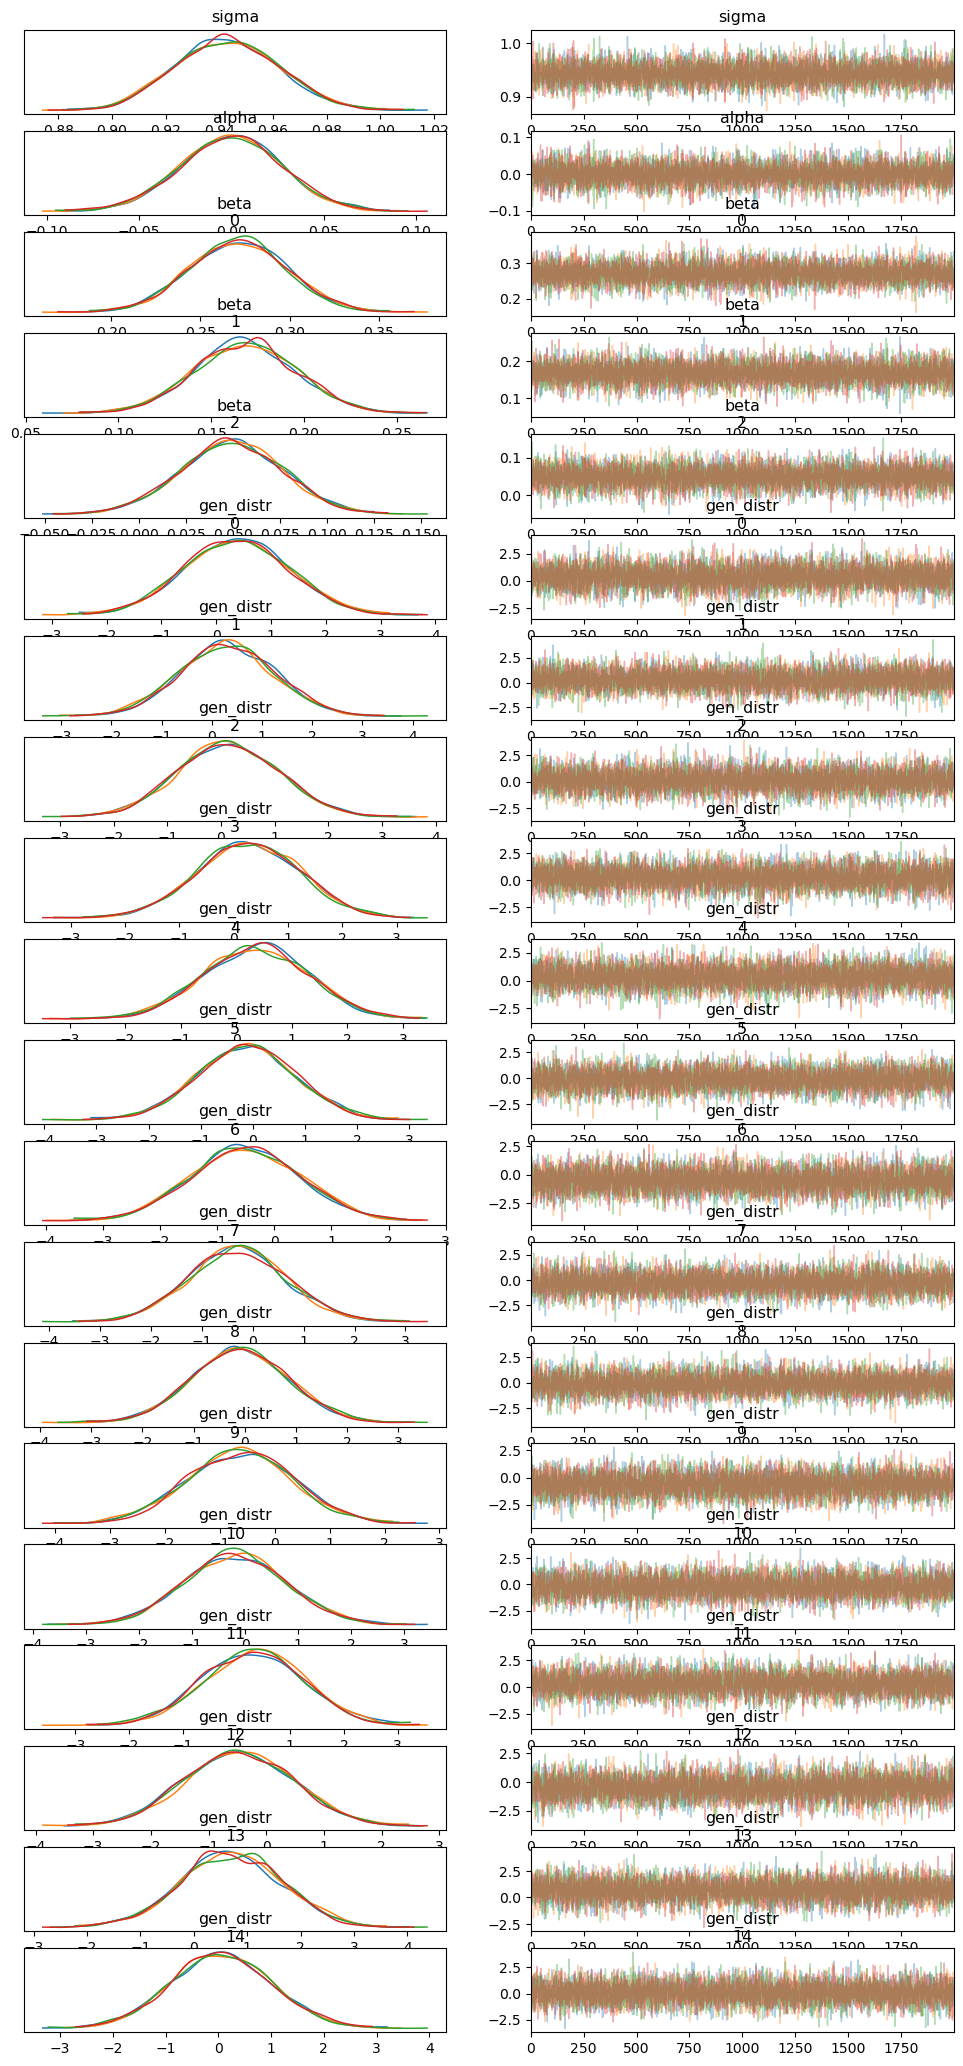

In [38]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

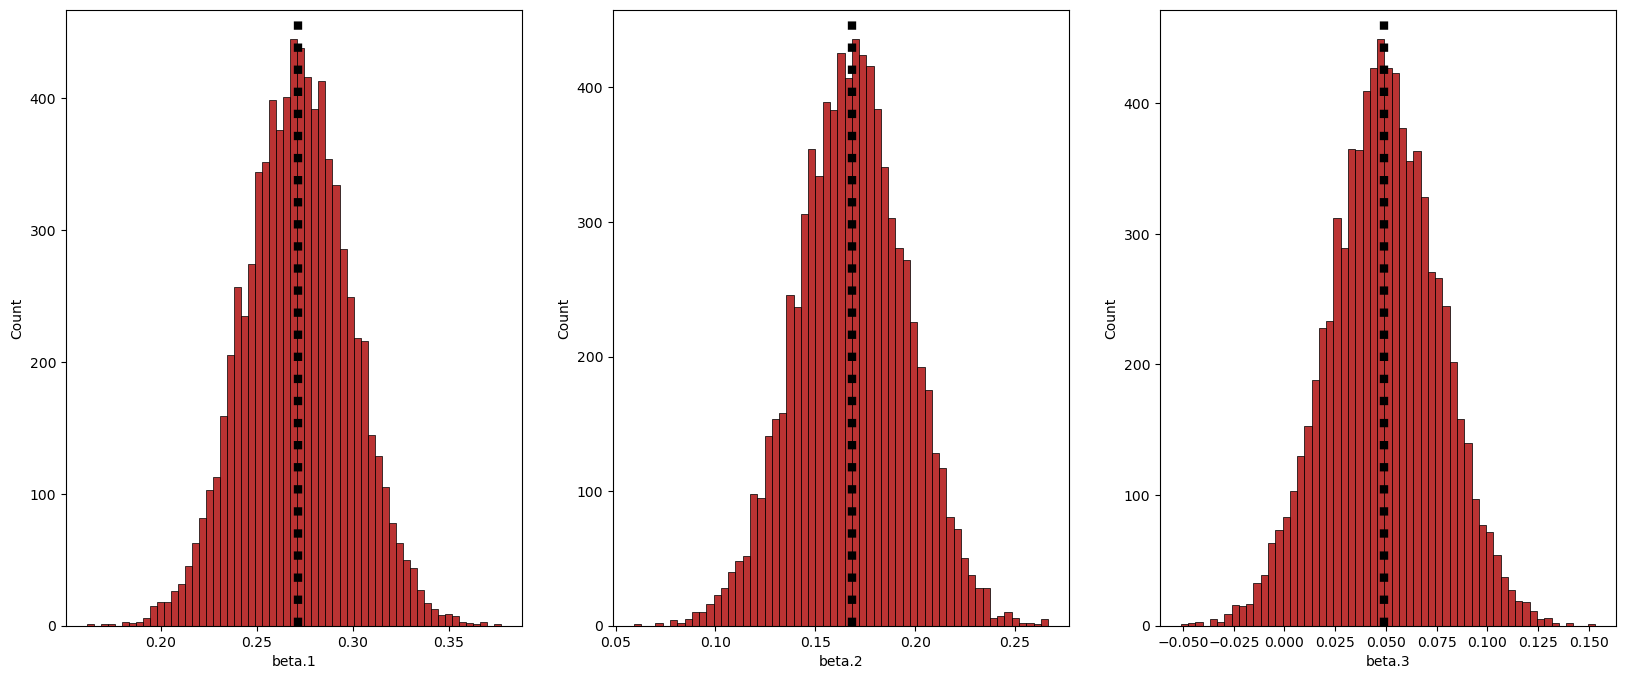

In [39]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)

### Problem 4

In [40]:
gen_distr = fit['gen_distr'] #Generative distribution (Training Set)
pred_distr = fit['pred_distr'] #Predictive distribution (Test Set)

gen_means = np.mean(gen_distr, axis=1) #Generative distribution means
pred_means = np.mean(pred_distr, axis=1) #Predictive distribution means

In [41]:
#Calculate the RMSE
train_rmse = np.sqrt(np.mean((gen_means - training_data_charges)**2))
test_rmse = np.sqrt(np.mean((pred_means - testing_data_charges)**2))

print(f"Training RMSE = {train_rmse}")
print(f"Test RMSE = {test_rmse}")

Training RMSE = 0.9404713892743835
Test RMSE = 0.9125955238988215
